In [1]:
import pandas as pd

# Read the CSV file into a DataFrame
df_mm = pd.read_csv("C:/Users/hagen/Downloads/NBA DATA/Teams/Transformed Data/mm_data.csv")

df_p = pd.read_csv("C:/Users/hagen/Downloads/NBA DATA/Teams/Transformed Data/p_data.csv")

In [3]:
import pandas as pd

team = df_mm.drop(columns=['Team', 'Year', 'Levels', 'L', 'PL'])
team1 = df_mm.drop(columns=['Team', 'Year', 'Champion', 'L', 'PL'])

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq

def find_alpha_and_plot(x, n, percentage=0.95):
    """
    Finds the alpha value such that the first x observations contain the given percentage of the total weight,
    and then plots the exponentially weighted coefficients with x-axis starting at 1 and a vertical marker at x.
    
    Parameters:
        x (int): Number of initial observations that should sum to the given percentage of the total weight.
        n (int): Total number of observations.
        percentage (float): Desired percentage of total weight to be contained in the first x observations (default is 95%).

    Returns:
        alpha (float): The solved alpha value.
    """
    # Define the equation to solve for alpha
    def alpha_equation(alpha, x, n, percentage):
        weights = np.array([(1 + alpha) ** i for i in range(n)])
        total_weight = np.sum(weights)
        first_x_weight = np.sum(weights[:x])
        return first_x_weight - percentage * total_weight

    # Solve for alpha in the range (-1, 0]
    alpha_solution = brentq(alpha_equation, -1 + 1e-6, 0, args=(x, n, percentage))

    # Compute exponentially weighted coefficients
    weights = np.array([(1 + alpha_solution) ** i for i in range(n)])
    coefficients = weights / np.sum(weights)

    # Plot the weights with x-axis starting at 1
    plt.figure(figsize=(8, 5))
    plt.bar(np.arange(1, n + 1), coefficients, color='skyblue', label='Weights')  # Start x-axis at 1
    plt.axvline(x, color='red', linestyle='--', label=f'{percentage*100:.0f}% of weight at x={x}')  # Vertical red dashed line

    # Plot formatting
    plt.title(f'Exponentially Weighted Coefficients (α = {alpha_solution:.4f}, {percentage*100:.1f}% in first {x} obs)')
    plt.xlabel('Index')
    plt.ylabel('Weight')
    plt.legend()
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.show()

    rounded_coefficients = np.round(coefficients, 4)  # Round to 4 decimal places
    nonzero_coefficients = rounded_coefficients[rounded_coefficients != 0]  # Filter out zeros
    
    print(f"alpha: {alpha_solution}")
    print(f"Most Significant Coefficients: {nonzero_coefficients}")

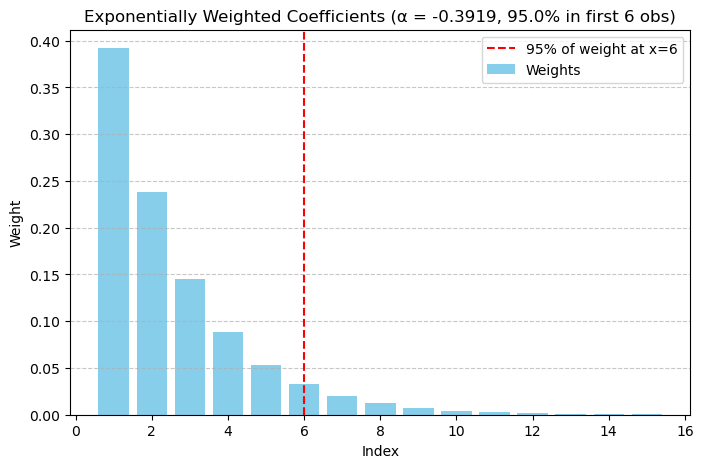

alpha: -0.3919387434920597
Most Significant Coefficients: [0.3922 0.2385 0.145  0.0882 0.0536 0.0326 0.0198 0.0121 0.0073 0.0045
 0.0027 0.0016 0.001  0.0006 0.0004]


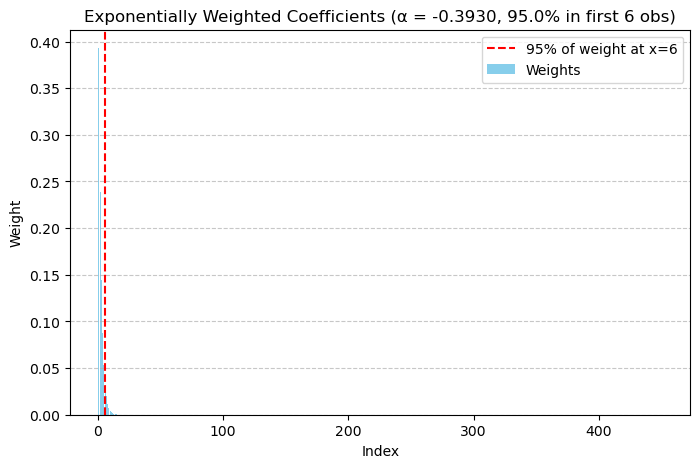

alpha: -0.39303776899708287
Most Significant Coefficients: [3.930e-01 2.386e-01 1.448e-01 8.790e-02 5.330e-02 3.240e-02 1.970e-02
 1.190e-02 7.200e-03 4.400e-03 2.700e-03 1.600e-03 1.000e-03 6.000e-04
 4.000e-04 2.000e-04 1.000e-04 1.000e-04]


In [208]:
find_alpha_and_plot(x=6, n=15, percentage=.95)
find_alpha_and_plot(x=6, n=450, percentage=.95)

In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances

def dim_reducer(df, alpha1, alpha2):
    # Getting the results (first column is 'y')
    y = df.iloc[:, 0]
   
    # Getting counts for 1's and 0's
    n1 = int(y.sum())
    n2 = int(len(y) - n1)
    n = n1 + n2

    # Getting dataframes for 1's and 0's of X variables
    df_ones = df[df.iloc[:, 0] == 1].iloc[:, 1:]  
    df_zeros = df[df.iloc[:, 0] == 0].iloc[:, 1:]

    # Getting coefficients for ewa's
    weights1 = np.array([(1+alpha1)**i for i in range(n2)])
    total_weights1 = np.sum(weights1)
    coefficients1 = weights1 / total_weights1

    weights2 = np.array([(1+alpha2)**i for i in range(n1-1)])
    total_weights2 = np.sum(weights2)
    coefficients2 = weights2 / total_weights2
    

    # Initializing the list of remaining features and selected features
    remaining_features = list(df_ones.columns)
    selected_features = []

    # Initialize paired results to store EWA for feature combinations
    paired_results = []
    feature_count = []
    feature_combinations = []

    # Iteratively find the best feature combinations
    while remaining_features:
        max_new_ewa = -float('inf')
        best_pair = None

        for feature in remaining_features:
            # Create a pair of selected features + new candidate feature
            current_features = selected_features + [feature]
            # Create DataFrames for the current features
            df_ones_current = df_ones[current_features]
            df_zeros_current = df_zeros[current_features]
            
            # Compute the distance matrix between df_ones_current and df_zeros_current
            dist_matrix = pairwise_distances(df_ones_current, df_zeros_current, metric='euclidean')
            dist_matrix = pd.DataFrame(dist_matrix)

            # Compute the distance matrix between each observation of 1's to all other 1's
            dist_matrix1s = pairwise_distances(df_ones_current, metric='euclidean')
            dist_matrix1s = pd.DataFrame(dist_matrix1s)

            # Sorting each row (1's) by how close it is to all the 0's
            sorted_dist_matrix = np.sort(dist_matrix, axis=1)

            # Sorting each row (1's) by how close it is to all the other 1's
            sorted_dist_matrix1s = np.sort(dist_matrix1s, axis=1)
            sorted_dist_matrix1s = sorted_dist_matrix1s[:, 1:]

            # Calculate the EWA for 1's vs 0's for the current feature pair
            ewa_1 = np.array([np.dot(row, coefficients1) for row in sorted_dist_matrix])

            # Calculate the EWA for 1's vs other 1's for the current feature pair
            ewa_2 = np.array([np.dot(row, coefficients2) for row in sorted_dist_matrix1s])

            # Calculate the mean EWA for the current pair
            mean_ewa = np.mean(ewa_1 - ewa_2)

            # If the mean EWA for the pair is the highest, update
            if mean_ewa > max_new_ewa:
                max_new_ewa = mean_ewa
                best_pair = current_features

        # Update the selected features and paired results
        selected_features = best_pair
        paired_results.append(max_new_ewa)
        feature_count.append(len(selected_features))
        feature_combinations.append(selected_features)

        # Update remaining features
        remaining_features = [feature for feature in remaining_features if feature not in selected_features]

        #print(f"Best features: {selected_features} with EWA: {max_new_ewa}")

    # Find the index of the maximum EWA
    max_ewa_index = np.argmax(paired_results)

    # Get the dimension at which the max EWA occurs
    max_ewa_dimension = feature_count[max_ewa_index]
    
    # Plotting the EWA progression after the loop
    plt.figure(figsize=(8, 5))
    plt.plot(feature_count, paired_results, label='EWA progression', color='skyblue')
    plt.axvline(x=max_ewa_index + 1, color='r', linestyle='--', label=f'Max EWA is in {max_ewa_index+1} dimensions')
    plt.xlabel('Number of Features')
    plt.ylabel('Exponentially Weighted Average (EWA)')
    plt.title('EWA Progression as Features Are Added')
    plt.grid(True)
    plt.legend()
    plt.show()

 # Print out paired results for the maximum EWA
    print(f"Paired results for max EWA (in {max_ewa_dimension} dimensions):")
    print(paired_results[max_ewa_index])

    # Print out the feature combination for the max EWA (only the first x features)
    best_combination = feature_combinations[max_ewa_index]
    print(f"Best feature combination for max EWA (first {max_ewa_dimension} features): {best_combination[:max_ewa_dimension]}")

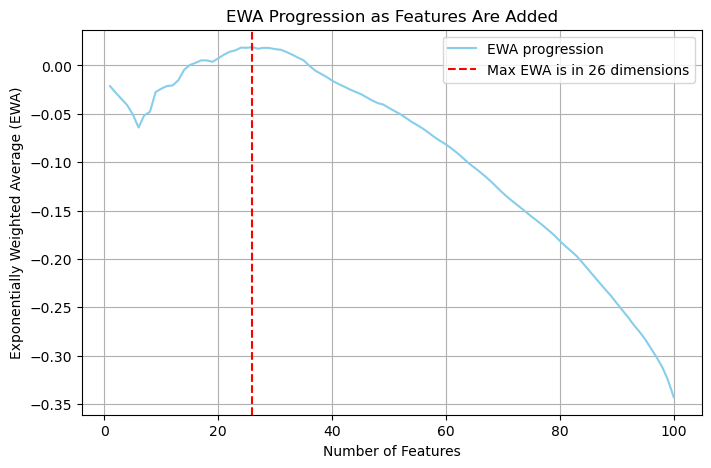

Paired results for max EWA (in 26 dimensions):
0.018781160067639597
Best feature combination for max EWA (first 26 features): ['PW', 'NRtg', 'MOV', 'SRS', 'W', 'corner3P%', 'Opp.%FGA_0-3ft', 'FT/FGA', '%FGA_16-3P', 'Opp.%FGA_2P', 'Opp.FG%', 'Age', 'Opp.2PA', '2P%', '%FGA_Layups', '%ASTd_3P', 'Opp.AST', 'Opp.2P', 'FTr', 'Opp.10-16ft_FG%', 'Opp.DRB', 'Opp.BLK', 'TOV%', 'Opp.%ASTd_2P', 'Opp.16-3P_FG%', 'FG%']


In [58]:
dim_reducer(team, alpha1 = -0.3919387434920597, alpha2 = -0.39303776899708287)

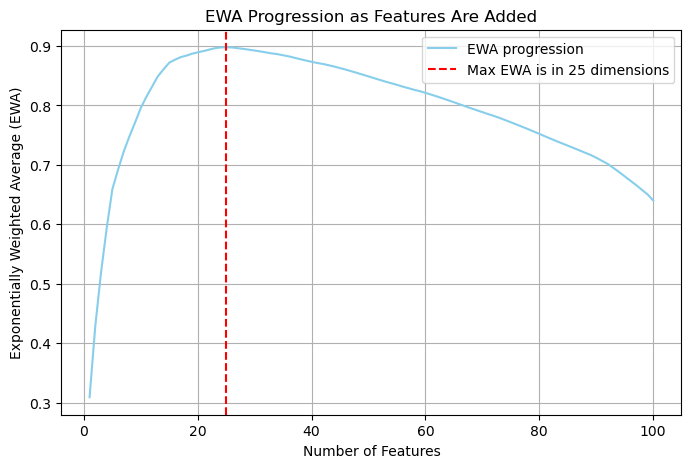

Paired results for max EWA (in 25 dimensions):
0.8979988044905783
Best feature combination for max EWA (first 25 features): ['W', 'PW', 'SRS', 'NRtg', 'MOV', '2P%', 'eFG%', 'TS%', 'FG%', '0-3ft_FG%', 'Age', 'ORtg', 'DRtg', 'Opp.BLK', 'Opp.FG%', 'Opp.eFG%', '%FGA_16-3P', 'Opp.%FGA_0-3ft', 'Opp.DRB', 'PTS', 'Opp.PTS', 'FG', 'Opp.16-3P_FG%', 'Opp.2P%', 'Opp.AST']


In [144]:
dim_reducer(team, alpha1 = 0, alpha2 = 0)

In [142]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_from_df(df, x_col, y_col, z_col):
    """
    Plots a 3D scatter plot using columns from a DataFrame.
    
    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        x_col (str): The column name for the X-axis data.
        y_col (str): The column name for the Y-axis data.
        z_col (str): The column name for the Z-axis data.
    """

    # Define colors for each level
    color_map = {
    0: 'gray',
    1: 'blue',
    2: 'green',
    3: 'red',
    4: 'black'
    }

    # Convert 'Levels' column to a NumPy array
    y_color = df['Levels'].values.ravel()

    # Map each level to a color
    color = np.array([color_map[level] for level in y_color])
    
    # Extract data for the 3D plot
    x = df[x_col]
    y = df[y_col]
    z = df[z_col]
    
    # Create the figure and axis
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot (ensure 'color' is a 1D array matching the length of the data)
    ax.scatter(x, y, z, c=color, marker='o', s=10, alpha=.5)

    # Labels
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_zlabel(z_col)

    # Title
    ax.set_title("Best 3 Variables")

    # Show the plot
    plt.show()


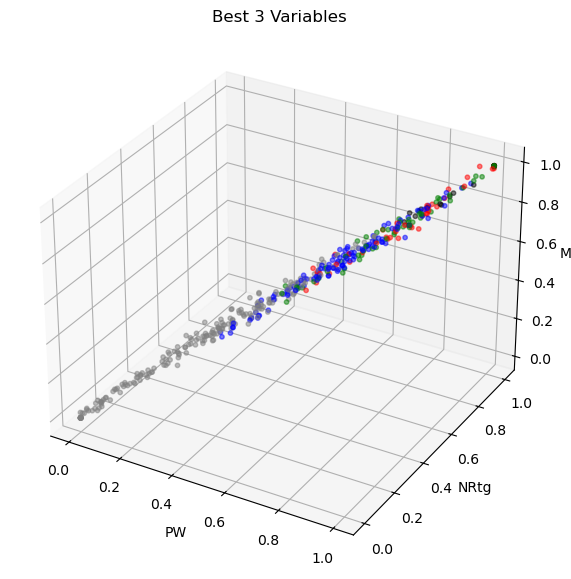

In [100]:
plot_3d_from_df(df_mm, 'PW', 'NRtg', 'MOV')

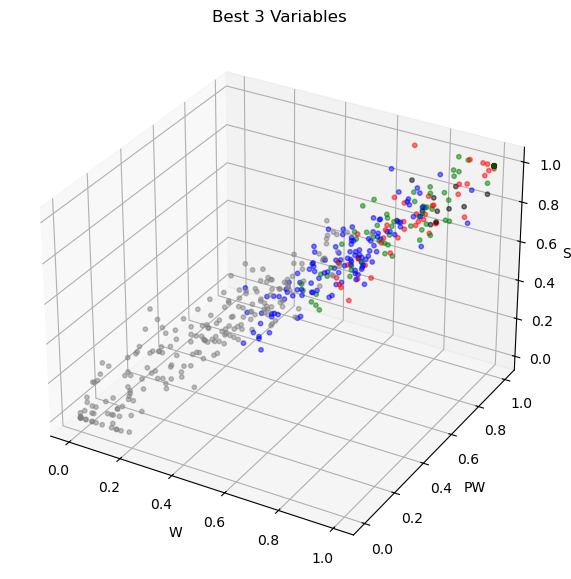

In [102]:
plot_3d_from_df(df_mm, 'W', 'PW', 'SRS')

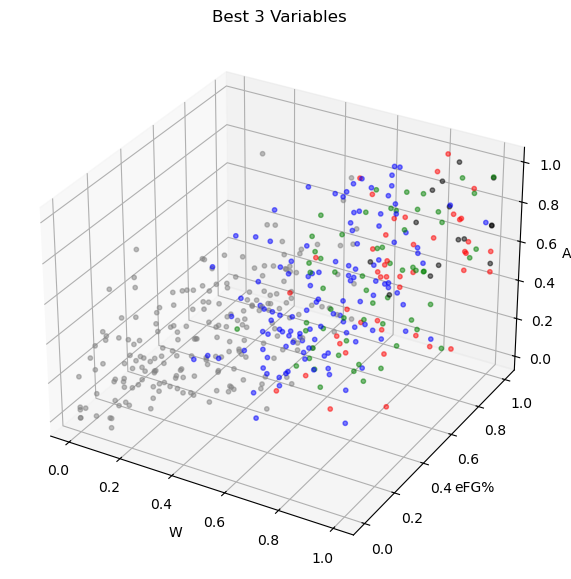

In [136]:
plot_3d_from_df(df_mm, 'W', 'eFG%', 'Age')

In [70]:
def algorithm_cv(df, alpha1, alpha2):
    """
    Custom cross-validation for predicting NBA champion using a neural network
    with a sigmoid activation function for binary classification (champion vs. non-champion).
    """
    results = []

    # Iterate over the years you want to predict (2014 to 2023)
    for test_year in range(2014, 2024):
        
        # Training data: the previous 5 years of data (e.g., 2009-2013 for 2014 prediction)
        train_data = df[df['Year'].isin(range(test_year - 5, test_year))]
        
        # Prepare df for algorithm
        X_train = train_data.drop(columns=['Team', 'Levels', 'Year', 'L', 'PL'])

        # Deploy the algorithm
        dim_reducer(X_train, alpha1, alpha2)

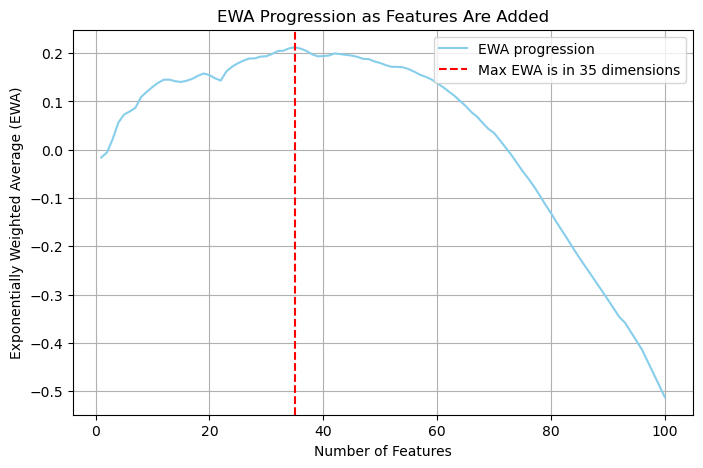

Paired results for max EWA (in 35 dimensions):
0.2123552881487758
Best feature combination for max EWA (first 35 features): ['W', 'Opp.%FGA_0-3ft', 'Opp.PTS', '%FGA_10-16ft', 'Opp.%FGA_Dunks', 'Opp.AST', 'Opp.10-16ft_FG%', 'Opp.eFG%', 'Pace', 'Opp.FT', 'ORtg', 'Opp.FG%', 'SRS', 'Opp.ORB', 'PW', '%FGA_16-3P', 'Opp.%FGA_10-16ft', 'NRtg', 'MOV', 'Opp.FG', 'PTS', 'Opp.STL', 'PF', 'Opp.FGA', 'Opp.Dunks', 'Opp.2P%', 'Opp.DRB', 'TOV%', 'STL', 'Opp.%FGA_corner3P', 'Opp.16-3P_FG%', 'Opp.%ASTd_2P', '%FGA_corner3P', '3-10ft_FG%', 'Opp.TRB']


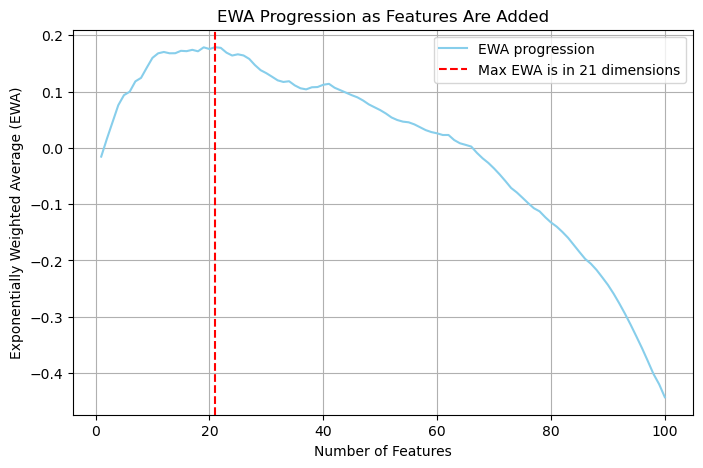

Paired results for max EWA (in 21 dimensions):
0.17877962692636012
Best feature combination for max EWA (first 21 features): ['W', 'Opp.%FGA_Dunks', 'ORtg', '3P%', 'Opp.PTS', '%FGA_10-16ft', 'ORB%', '%FGA_16-3P', 'Opp.10-16ft_FG%', 'Opp.AST', 'Opp.%FGA_0-3ft', 'PW', 'NRtg', 'Opp.%FGA_10-16ft', 'MOV', 'SRS', 'Opp.%ASTd_2P', 'FG%', 'corner3P%', 'Opp.FG', 'TOV%']


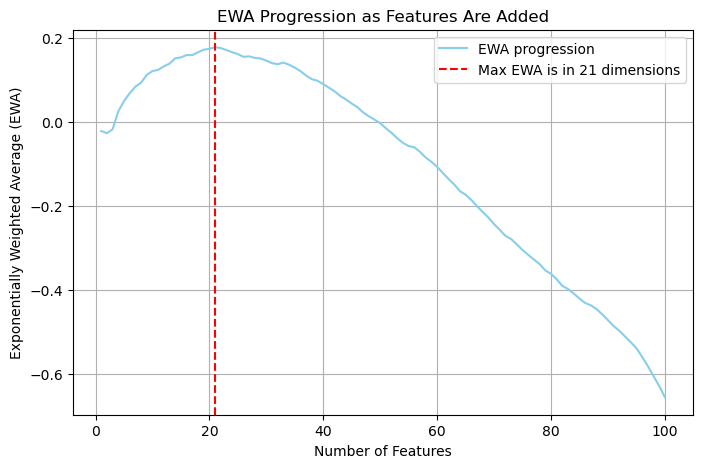

Paired results for max EWA (in 21 dimensions):
0.17835812988142746
Best feature combination for max EWA (first 21 features): ['%FGA_0-3ft', 'Opp.Dunks', 'Opp.PTS', '%FGA_10-16ft', 'Opp.%FGA_10-16ft', 'Opp.FG', '%FGA_3-10ft', 'Opp.%FGA_Dunks', 'PW', 'Age', 'Opp.FTA', '%ASTd_3P', 'Opp.16-3P_FG%', 'Opp.10-16ft_FG%', '%FGA_Layups', 'Opp.FG%', 'Dunks', 'Opp.FT/FGA', 'NRtg', 'Opp.%FGA_corner3P', 'MOV']


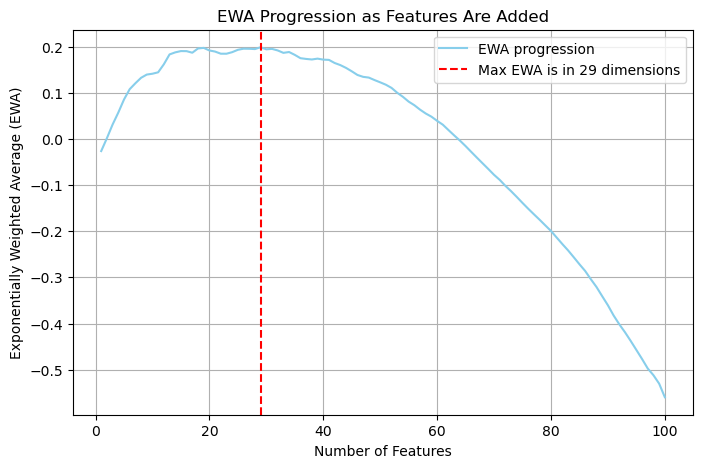

Paired results for max EWA (in 29 dimensions):
0.19860354094407132
Best feature combination for max EWA (first 29 features): ['Opp.PTS', 'FG', 'Opp.%FGA_Dunks', '2PA', 'MOV', 'FT%', 'ORtg', '%FGA_10-16ft', 'SRS', 'Opp.Dunks', 'DRtg', 'corner3P%', 'Layups', 'Opp.0-3ft_FG%', 'NRtg', 'PW', '2P', '0-3ft_FG%', 'FGA_Dist', 'Opp.2PA', 'W', 'AST', '%FGA_2P', '%FGA_Layups', 'Opp.%ASTd_3P', 'ORB%', '%FGA_0-3ft', '%FGA_3P', '%ASTd_3P']


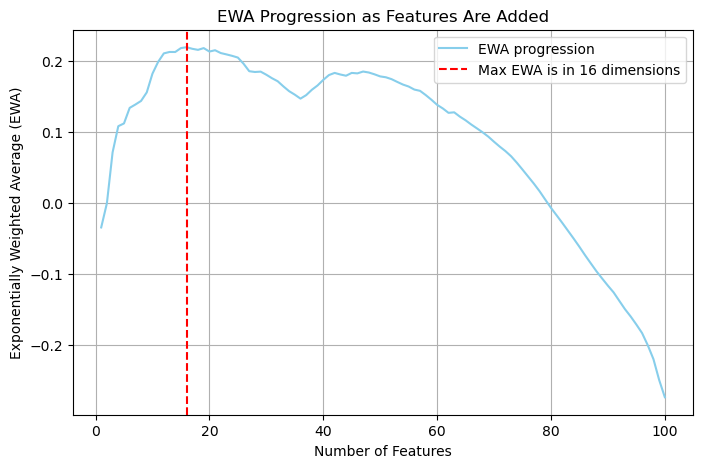

Paired results for max EWA (in 16 dimensions):
0.21944162159830718
Best feature combination for max EWA (first 16 features): ['PW', 'Opp.0-3ft_FG%', 'Opp.%FGA_16-3P', 'TRB', 'Opp.2P', 'MOV', 'NRtg', 'corner3P%', 'Age', 'FGA_Dist', 'Opp.%ASTd_3P', 'W', 'SRS', 'DRtg', 'DRB', 'ORtg']


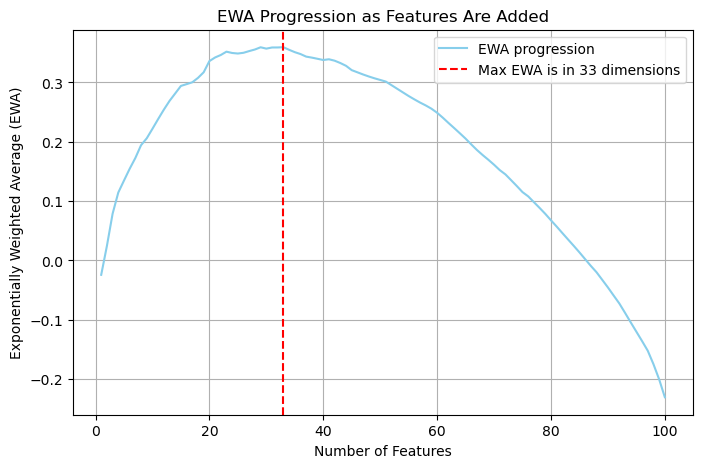

Paired results for max EWA (in 33 dimensions):
0.3594192370096288
Best feature combination for max EWA (first 33 features): ['Opp.%FGA_3P', 'FG%', 'PF', '%ASTd_3P', 'Opp.2P%', 'Opp.PTS', 'Opp.2P', 'Age', 'Opp.%FGA_2P', 'corner3P%', 'SOS', 'eFG%', 'FTr', 'ORtg', 'Opp.FGA_Dist', 'AST', 'FT', '2P%', 'DRB%', '%FGA_16-3P', 'Opp.3PA', '16-3P_FG%', 'FT/FGA', 'PW', 'Opp.2PA', 'Opp.%FGA_3-10ft', 'Opp.AST', 'Opp.%FGA_Layups', '%ASTd_2P', 'Opp.%ASTd_2P', 'Opp.FT', 'Opp.%FGA_0-3ft', 'MOV']


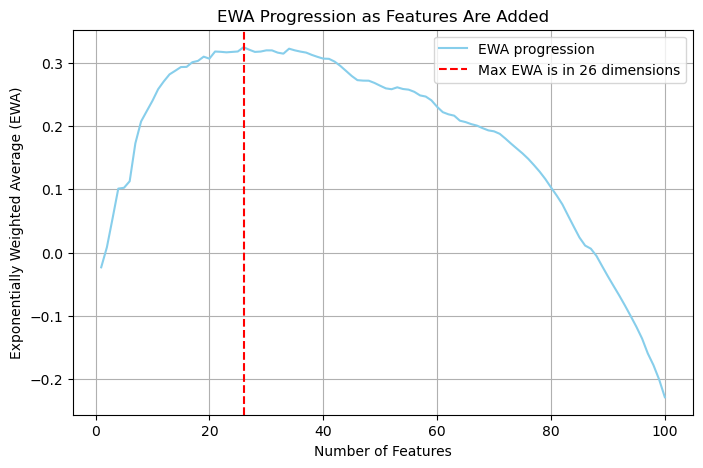

Paired results for max EWA (in 26 dimensions):
0.32468308253816713
Best feature combination for max EWA (first 26 features): ['Opp.%FGA_3P', 'W', 'Opp.0-3ft_FG%', 'Opp.TRB', 'Opp.%FGA_2P', 'Age', 'Opp.FT', 'Opp.TOV%', 'Opp.%FGA_16-3P', 'corner3P%', 'DRtg', 'Opp.2P', 'PW', 'Opp.3P', 'Opp.%FGA_0-3ft', 'NRtg', 'FTr', 'Opp.FTA', 'Opp.AST', 'SRS', 'PF', 'Opp.FGA_Dist', 'MOV', 'Opp.%FGA_10-16ft', 'Opp.3P%', 'Opp.%FGA_Layups']


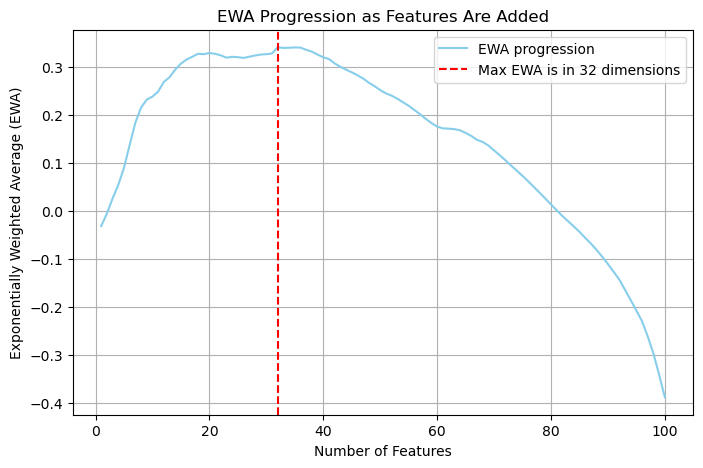

Paired results for max EWA (in 32 dimensions):
0.3414602955037685
Best feature combination for max EWA (first 32 features): ['SRS', 'Opp.%FGA_3P', 'FG', '%ASTd_3P', 'Pace', 'STL', 'eFG%', 'Opp.%FGA_0-3ft', 'NRtg', '%FGA_16-3P', 'FT', 'Opp.2P%', 'W', 'Opp.%FGA_2P', 'ORtg', 'Opp.AST', 'Opp.FT/FGA', 'TS%', '2P%', 'FGA_Dist', 'MOV', 'PTS', 'Opp.2PA', 'Opp.FT%', '2PA', 'Age', 'corner3P%', 'FT/FGA', 'Opp.FGA', 'Opp.3PA', 'Opp.%ASTd_2P', 'Opp.FG']


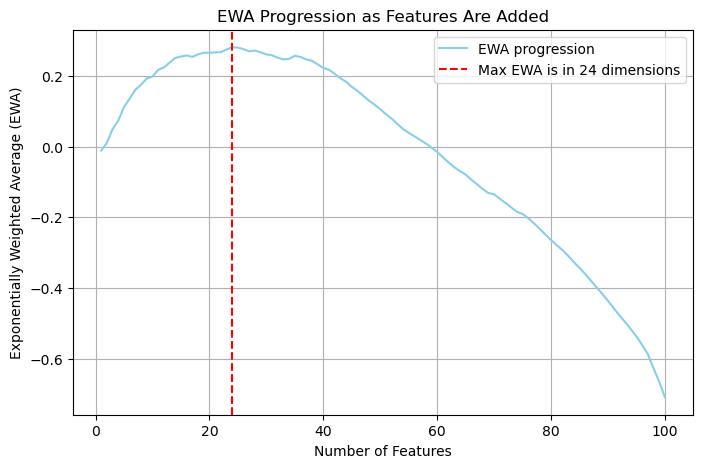

Paired results for max EWA (in 24 dimensions):
0.28197422670224787
Best feature combination for max EWA (first 24 features): ['SRS', 'STL', 'FG%', '3-10ft_FG%', 'Opp.eFG%', 'Opp.%FGA_3P', 'Opp.%FGA_16-3P', 'Opp.%FGA_2P', 'NRtg', '%FGA_16-3P', 'Pace', 'FT/FGA', 'PW', '2P%', 'MOV', 'Opp.TOV', 'TOV', 'FG', 'Age', '0-3ft_FG%', 'FT', 'Opp.DRB', 'Opp.%FGA_corner3P', 'Opp.0-3ft_FG%']


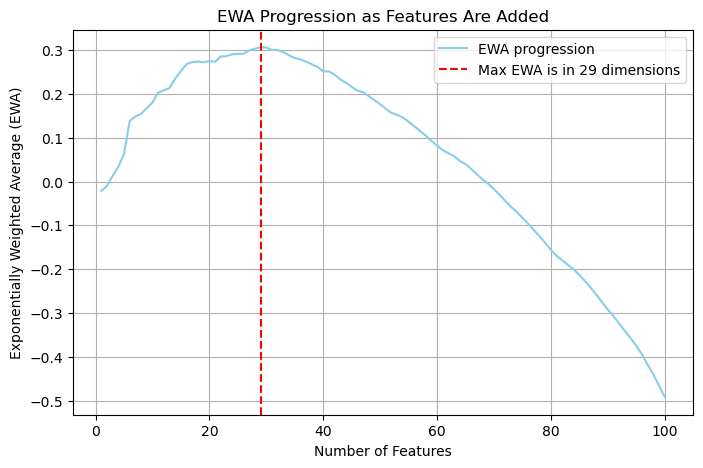

Paired results for max EWA (in 29 dimensions):
0.3066578505460316
Best feature combination for max EWA (first 29 features): ['NRtg', '2P%', 'FG%', '3-10ft_FG%', '%FGA_16-3P', 'Pace', 'MOV', 'STL', 'Opp.%FGA_2P', '%FGA_10-16ft', 'ORB', 'SRS', 'Opp.16-3P_FG%', 'Dunks', 'Opp.eFG%', '0-3ft_FG%', 'PW', 'FT/FGA', 'TS%', '%FGA_Dunks', 'FG', 'FT%', 'DRtg', 'Opp.2PA', 'W', 'Opp.%ASTd_3P', 'TOV', 'Opp.%FGA_3P', 'Opp.DRB']


In [74]:
algorithm_cv(df_mm, alpha1 = -0.7751763481782122, alpha2 = -0.77639320225002)

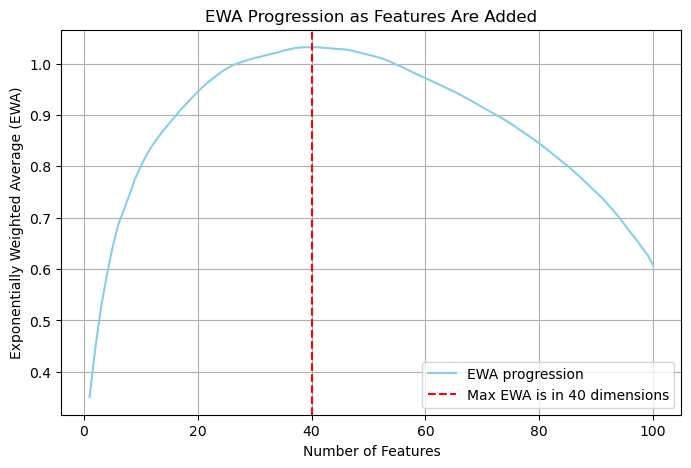

Paired results for max EWA (in 40 dimensions):
1.032084531140434
Best feature combination for max EWA (first 40 features): ['W', 'PW', 'SRS', 'NRtg', 'MOV', 'Opp.PTS', 'Opp.2P%', 'Age', 'DRtg', 'Opp.FG%', '3-10ft_FG%', 'PF', 'Opp.FG', '%FGA_10-16ft', 'Opp.AST', 'Opp.FT', 'Opp.eFG%', 'Opp.BLK', 'PTS', 'Opp.FTA', 'Pace', 'Opp.%FGA_Dunks', 'Opp.%FGA_0-3ft', 'Opp.ORB', 'ORtg', 'FG%', 'Opp.%FGA_corner3P', 'Opp.10-16ft_FG%', 'Opp.FT/FGA', 'Opp.%FGA_Layups', 'Opp.DRB', 'Opp.Layups', 'Opp.Dunks', 'TS%', 'eFG%', '2P%', 'Opp.3-10ft_FG%', 'DRB%', '%FGA_0-3ft', 'Opp.TRB']


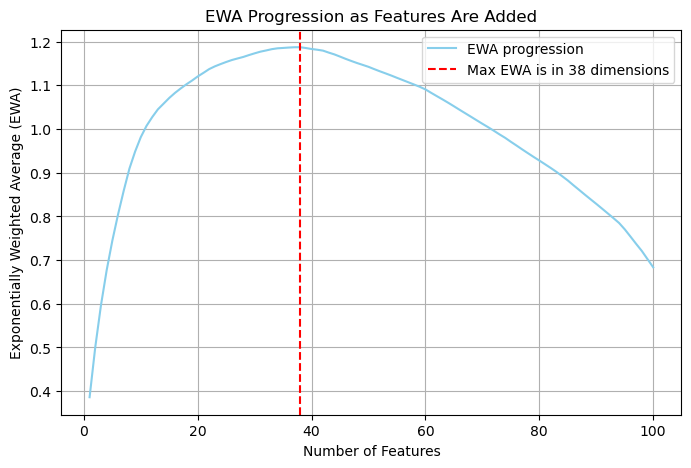

Paired results for max EWA (in 38 dimensions):
1.1871730212985703
Best feature combination for max EWA (first 38 features): ['W', 'FG%', 'TS%', 'PW', 'eFG%', 'SRS', 'MOV', 'NRtg', 'Opp.AST', '0-3ft_FG%', 'Opp.PTS', 'ORtg', 'Opp.%FGA_Dunks', '%FGA_10-16ft', 'Opp.%ASTd_2P', 'Opp.BLK', '2P%', 'Opp.FG', 'Opp.10-16ft_FG%', 'DRtg', 'ORB%', 'Opp.Layups', 'Opp.%FGA_0-3ft', 'Opp.%FGA_10-16ft', 'PTS', '3P%', '%FGA_3-10ft', 'Age', 'ORB', 'PF', 'Opp.Dunks', 'Opp.FG%', 'Opp.2P%', '3-10ft_FG%', 'FT%', 'Opp.%FGA_Layups', '%FGA_0-3ft', '%FGA_16-3P']


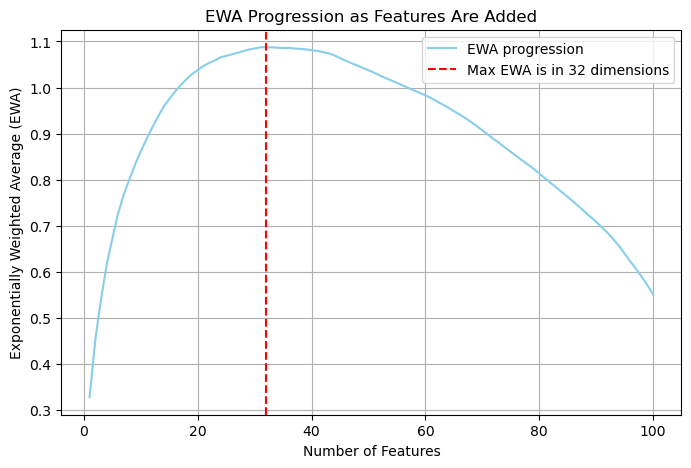

Paired results for max EWA (in 32 dimensions):
1.087530476782237
Best feature combination for max EWA (first 32 features): ['PW', 'W', 'MOV', 'NRtg', 'SRS', 'Opp.%FGA_10-16ft', '0-3ft_FG%', 'FG%', 'Opp.AST', 'ORtg', 'Opp.PTS', 'Opp.%FGA_Dunks', 'eFG%', 'TS%', '2P%', 'Opp.FG', '%FGA_0-3ft', 'Opp.Dunks', '%FGA_10-16ft', 'Opp.10-16ft_FG%', 'Opp.%FGA_0-3ft', 'Opp.Layups', 'Age', 'DRtg', 'Opp.%FGA_Layups', 'Opp.2P%', '%FGA_3-10ft', '%FGA_Layups', 'Opp.BLK', '%ASTd_3P', 'Opp.FG%', 'Opp.16-3P_FG%']


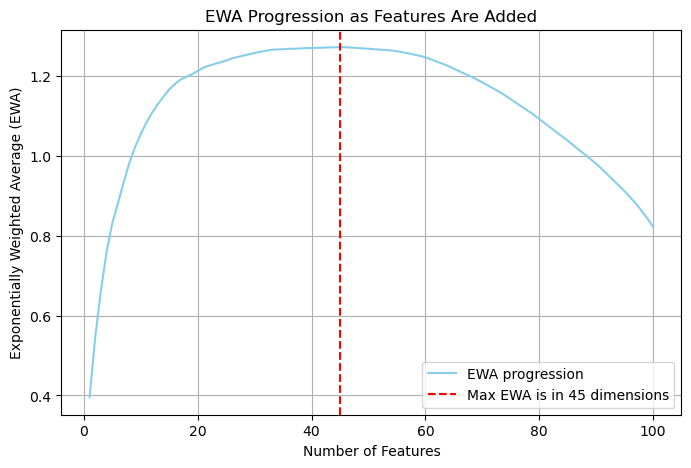

Paired results for max EWA (in 45 dimensions):
1.2715145758147917
Best feature combination for max EWA (first 45 features): ['PW', 'W', 'NRtg', 'MOV', 'SRS', 'ORtg', '0-3ft_FG%', 'eFG%', 'FG%', 'TS%', '2P%', 'corner3P%', '3P', 'Opp.PTS', 'Opp.%FGA_Dunks', '16-3P_FG%', '3PA', 'Opp.0-3ft_FG%', '%FGA_2P', '3P%', '%FGA_3P', 'FGA_Dist', 'Opp.Dunks', 'Age', 'Opp.BLK', 'DRtg', 'PTS', 'Opp.FG', 'AST', '%FGA_10-16ft', 'Opp.Layups', 'ORB%', '%FGA_Layups', 'TOV%', 'Opp.2P%', 'Opp.3P%', 'FT%', 'FG', 'ORB', 'TOV', 'Opp.AST', 'Opp.%FGA_10-16ft', '%FGA_0-3ft', '%FGA_16-3P', 'Opp.%FGA_0-3ft']


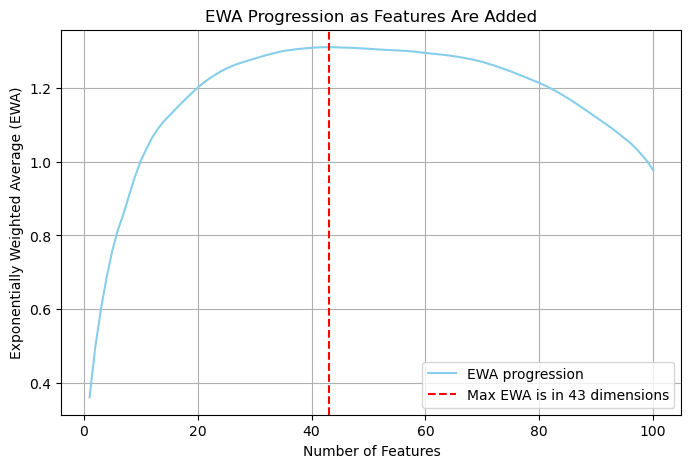

Paired results for max EWA (in 43 dimensions):
1.3095925168885265
Best feature combination for max EWA (first 43 features): ['PW', 'MOV', 'NRtg', 'SRS', 'W', 'AST', 'ORtg', 'eFG%', '0-3ft_FG%', 'FG%', 'TS%', '2P%', 'FG', 'Opp.%FGA_3-10ft', 'DRB', 'corner3P%', '3P%', 'Opp.2PA', 'Age', 'Opp.2P%', '16-3P_FG%', 'Opp.%FGA_16-3P', 'Opp.eFG%', 'FGA_Dist', 'PTS', 'Opp.PTS', 'Opp.2P', 'Opp.BLK', 'Opp.%ASTd_3P', 'Opp.0-3ft_FG%', '3P', 'Opp.%FGA_Dunks', 'ORB%', 'TRB', 'FT%', 'Opp.%FGA_3P', 'Opp.%FGA_2P', 'Opp.3P', 'Opp.%FGA_corner3P', 'DRtg', 'Opp.PF', 'Opp.%FGA_0-3ft', 'ORB']


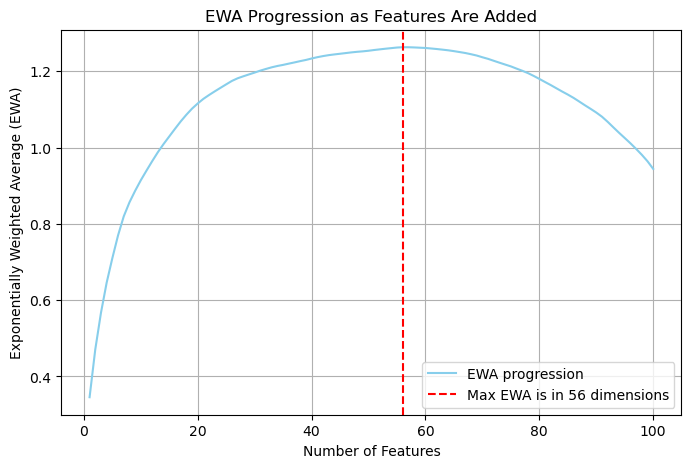

Paired results for max EWA (in 56 dimensions):
1.2631810872162335
Best feature combination for max EWA (first 56 features): ['PW', 'MOV', 'NRtg', 'SRS', 'W', '2P%', 'ORtg', 'corner3P%', 'eFG%', 'Opp.3P', 'TS%', 'FG%', 'SOS', 'Opp.%FGA_2P', 'Opp.%FGA_3P', 'Age', 'Opp.2P%', '16-3P_FG%', 'Opp.eFG%', 'Opp.BLK', '0-3ft_FG%', 'PF', 'Opp.2PA', 'ORB%', 'Opp.%FGA_3-10ft', 'FGA_Dist', 'Opp.2P', 'Opp.PTS', 'Opp.%FGA_16-3P', 'Opp.0-3ft_FG%', 'Opp.FG%', 'FTr', 'Opp.3PA', 'Opp.AST', 'FG', 'FT%', 'Opp.TOV%', 'Opp.%FGA_Dunks', '%FGA_Layups', 'Opp.3P%', 'TRB', 'FTA', 'Opp.FGA_Dist', '3P', 'Opp.16-3P_FG%', 'Opp.%FGA_10-16ft', 'Opp.%FGA_0-3ft', 'Opp.PF', 'DRtg', 'PTS', 'AST', '%FGA_16-3P', '3P%', 'Opp.FTA', 'ORB', '%ASTd_3P']


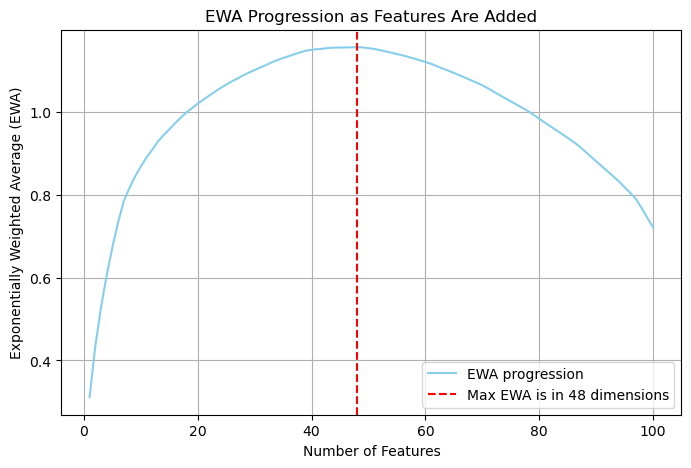

Paired results for max EWA (in 48 dimensions):
1.157304682873368
Best feature combination for max EWA (first 48 features): ['PW', 'SRS', 'NRtg', '2P%', 'MOV', 'W', 'corner3P%', 'Opp.%FGA_3P', 'Opp.%FGA_2P', 'Opp.3P', 'Age', 'eFG%', 'FG%', '0-3ft_FG%', 'TS%', 'ORtg', 'Opp.FGA_Dist', 'Opp.eFG%', 'Opp.%FGA_16-3P', 'Opp.%FGA_3-10ft', 'Opp.FTA', 'Opp.%ASTd_2P', 'PF', 'Opp.FT', 'Opp.2P%', 'Opp.0-3ft_FG%', 'Opp.BLK', 'Opp.DRB', 'Opp.%FGA_Layups', 'Opp.3PA', 'Opp.2P', 'Opp.TRB', 'DRtg', 'Opp.AST', 'Opp.FG%', 'Opp.3P%', 'Opp.TOV%', 'Opp.%FGA_0-3ft', 'TRB', 'Opp.FT/FGA', 'Opp.2PA', 'FT/FGA', 'FG', '%FGA_Layups', '%FGA_16-3P', 'FT', 'Opp.corner3P%', 'Opp.Layups']


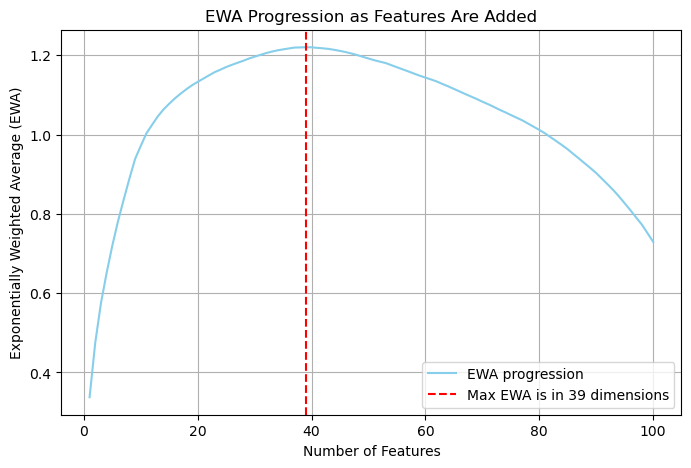

Paired results for max EWA (in 39 dimensions):
1.220152605643247
Best feature combination for max EWA (first 39 features): ['W', 'FG%', 'SRS', 'PW', 'NRtg', 'MOV', 'eFG%', 'FG', '2P%', 'Age', 'TS%', '0-3ft_FG%', '2P', 'PTS', 'Opp.%FGA_3P', 'Opp.%FGA_2P', 'ORtg', '%FGA_16-3P', 'Pace', 'FT', 'corner3P%', 'Opp.2P%', 'Opp.AST', 'STL', '2PA', 'Opp.DRB', 'Opp.2P', 'Opp.FG%', 'DRtg', 'Opp.TRB', 'AST', 'Opp.2PA', 'FT/FGA', 'TOV', 'Opp.0-3ft_FG%', 'Opp.%FGA_0-3ft', '10-16ft_FG%', '%FGA_3P', '%FGA_2P']


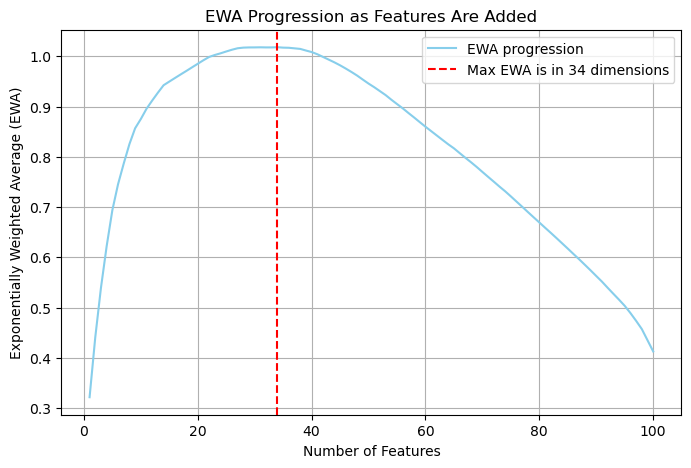

Paired results for max EWA (in 34 dimensions):
1.0182354472166235
Best feature combination for max EWA (first 34 features): ['SRS', 'NRtg', 'STL', 'PW', 'MOV', 'W', 'eFG%', '2P%', 'TS%', 'Age', 'FG%', 'Opp.%FGA_3P', 'Opp.FG%', 'Opp.%FGA_2P', 'Opp.TRB', 'Opp.TOV', '0-3ft_FG%', 'Pace', 'AST', 'Opp.2P%', 'Opp.DRB', 'ORtg', 'TOV', '%FGA_16-3P', 'DRtg', 'FT/FGA', 'Opp.2PA', 'PTS', 'Opp.AST', 'FT', 'Opp.2P', 'Opp.TOV%', 'Opp.eFG%', 'FG']


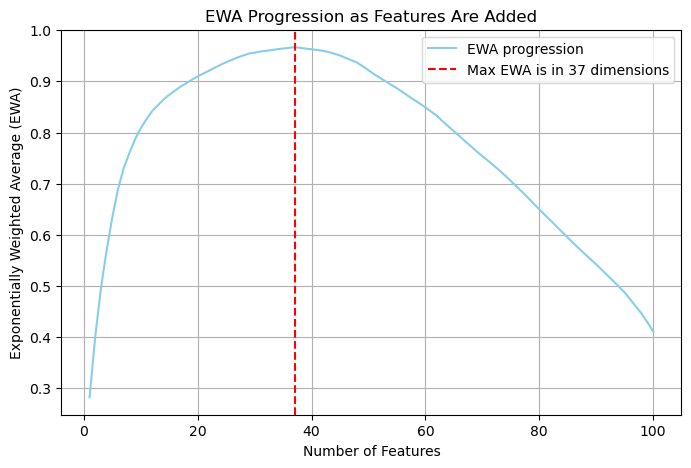

Paired results for max EWA (in 37 dimensions):
0.9667609604865717
Best feature combination for max EWA (first 37 features): ['SRS', '2P%', 'NRtg', 'PW', 'MOV', 'W', 'TS%', 'eFG%', 'STL', 'AST', 'FG%', 'FT/FGA', '%FGA_16-3P', '0-3ft_FG%', 'Opp.2PA', 'Opp.DRB', 'TOV', 'Opp.TRB', '%FGA_Layups', 'Layups', 'Pace', 'Age', 'FT', 'ORtg', 'DRtg', 'Opp.%FGA_3P', 'Opp.%FGA_2P', 'TOV%', 'Opp.FG%', 'DRB%', 'Opp.2P', 'Opp.TOV', 'FG', '%FGA_10-16ft', 'PTS', 'Opp.ORB', 'Opp.16-3P_FG%']


In [72]:
algorithm_cv(df_mm, alpha1 = 0, alpha2 = 0)